In [1]:
from math import log
import math
import numpy as np
import gurobipy as gp
import matplotlib.pyplot as plt
from astronomical_matching.utils import neg_log_bayes, stirling2
from gurobipy import GRB, Model, quicksum
import pandas as pd
import time
from astronomical_matching.cop_kmeans import run_cop_kmeans
from astronomical_matching.kmeans import run_kmeans
from astronomical_matching.dirilp import setup_dirilp, dirilp
from astronomical_matching.miqcp import setup_miqcp_model, find_max_clusters, miqcp
from astronomical_matching.chainbreaker import chain_breaking
from astronomical_matching.simulate import simulate_two_objects, simulate_objects_on_circle
from astronomical_matching.utils import load_data, neg_log_bayes, neg_log_bayes_adjusted
import itertools
from tqdm import tqdm
import astronomical_matching.constants as constants
from scipy.spatial.distance import pdist
from collections import defaultdict

import matplotlib as mpl
import pylab

from sklearn.metrics import normalized_mutual_info_score

plt.rcParams['text.usetex'] = True

In [2]:
plt.rc('font', family='serif')
plt.rc('text', usetex=False)
plt.rc('axes', axisbelow=True)
label_size = 15
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size 
mpl.rcParams['axes.labelsize'] = label_size
mpl.rcParams['axes.titlesize'] = label_size
mpl.rcParams['figure.titlesize'] = label_size
mpl.rcParams['lines.markersize'] = label_size
mpl.rcParams['grid.linewidth'] = 2.5
mpl.rcParams['legend.fontsize'] = label_size
pylab.rcParams['xtick.major.pad']=5
pylab.rcParams['ytick.major.pad']=5

lss = ['--',  ':', '-.', '-', '--', '-.', ':', '-', '--', '-.', ':', '-']
mss = ['x', 'o', '>', 's', 'D', '>', 'D', '>', 's', 'o', 'D','x', 'o', '>', 's', 'D', '>', 'D', '>', 's', 'o', 'D','x', 'o', '>', 's', 'D', '>', 'D', '>', 's', 'o', 'D','x', 'o', '>', 's', 'D', '>', 'D', '>', 's', 'o', 'D']

In [7]:
def plot_data(data_df: pd.DataFrame, title: str, out: str = None):
    # plt.figure(figsize=(7,7))

    ax = plt.gca()
    plt.title(title)

    left_x = []
    right_x = []
    top_y = []
    bottom_y = []

    for x, y, color, size in zip(data_df["coord1 (arcseconds)"],
                                data_df["coord2 (arcseconds)"],
                                data_df["ImageID"],
                                data_df["Sigma"]):
        # plot circles using the RGBA colors
        circle = plt.Circle((x, y), size, color=(0.85,0.85,0.85), fill=True)
        ax.add_artist(circle)

        left_x.append(x - size)
        right_x.append(x + size)
        top_y.append(y + size)
        bottom_y.append(y - size)

    plt.scatter(data_df["coord1 (arcseconds)"], data_df["coord2 (arcseconds)"], s=15, c=data_df["ImageID"], cmap="tab10")

    plt.xlabel("x (arcseconds)")
    plt.ylabel("y (arcseconds)")

    plt.xlim([min(left_x)-0.05, max(right_x)+0.05])
    plt.ylim([min(bottom_y)-0.05, max(top_y)+0.05])
    # plt.xlim([-0.65,0.9])
    # plt.ylim([-0.5,0.4])

    print([min(left_x)-0.05, max(right_x)+0.05], [min(bottom_y)-0.05, max(top_y)+0.05])

    plt.tight_layout()
    ax.set_aspect("equal")

    if out:
        plt.savefig(out, bbox_inches='tight')

    plt.show()

def plot_objects(data_df: pd.DataFrame, title: str = None, out: str = None, colors: list = None):
    fig = plt.figure(figsize=(5,5))

    ax = plt.gca()
    if title is not None:
        plt.title(title)

    left_x = []
    right_x = []
    top_y = []
    bottom_y = []

    if colors is None:
        colors = data_df["ObjectID"]
    else:
        colors = pd.Series(colors)

    for x, y, color, size in zip(data_df["coord1 (arcseconds)"],
                                data_df["coord2 (arcseconds)"],
                                data_df["ImageID"],
                                data_df["Sigma"]):
        # plot circles using the RGBA colors
        circle = plt.Circle((x, y), size, color=(0.85,0.85,0.85), fill=True)
        ax.add_artist(circle)

        left_x.append(x - size)
        right_x.append(x + size)
        top_y.append(y + size)
        bottom_y.append(y - size)

    # Step 3: Scatter plot with colors
    unique_colors = np.sort(colors.unique())
    for color in unique_colors:
        subset = data_df[colors == color]
        ax.scatter(subset['coord1 (arcseconds)'], 
                   subset['coord2 (arcseconds)'], 
                   s=15,
                   label=f'Obj. {color+1}', 
                   marker=mss[color],
                   cmap='tab10')
    ax.legend()

    plt.xlabel("x (arcseconds)")
    plt.ylabel("y (arcseconds)")

    plt.xlim([min(left_x)-0.05, max(right_x)+0.05])
    plt.ylim([min(bottom_y)-0.05, max(top_y)+0.05])
    # plt.xlim([-0.65,0.9])
    # plt.ylim([-0.5,0.4])

    print([min(left_x)-0.05, max(right_x)+0.05], [min(bottom_y)-0.05, max(top_y)+0.05])

    plt.tight_layout()
    ax.set_aspect("equal")

    if out:
        plt.savefig(out, bbox_inches='tight')

    return fig, ax

def plot_lined(labels, data_df):
    plt.figure()
    loc_tups = [(row["coord1 (arcseconds)"], row["coord2 (arcseconds)"]) for _, row in data_df.iterrows()]

    label_dict = defaultdict(list)
    for tup, label in zip(loc_tups, labels):
        label_dict[label].append(tup)
        
    for label, tup_list in label_dict.items():
        if len(tup_list) == 1:
            pairs = [tup_list]
        else:
            pairs = list(itertools.combinations(tup_list, 2))
        for pair in pairs:
            x = []
            y = []
            for tup in pair:
                x.append(tup[0])
                y.append(tup[1])
            plt.plot(x, y, color='green', marker='o', linestyle='-', linewidth=1, markersize=2)

# Plot runtime plots

In [5]:
runtimes_all = pd.read_csv('runtime-all.csv')
runtimes_all.replace(1e9, np.nan, inplace=True)
runtimes_all_avg = runtimes_all.groupby('number of catalogs').mean()
runtimes_all_std = runtimes_all.groupby('number of catalogs').std()

runtimes_2 = pd.read_csv('runtime-all-max_k_2.csv')
runtimes_2.replace(1e9, np.nan, inplace=True)
runtimes_2_avg = runtimes_2.groupby('number of catalogs').mean()
runtimes_2_std = runtimes_2.groupby('number of catalogs').std()

runtimes_4 = pd.read_csv('runtime-all-max_k_4.csv')
runtimes_4.replace(1e9, np.nan, inplace=True)
runtimes_4_avg = runtimes_4.groupby('number of catalogs').mean()
runtimes_4_std = runtimes_4.groupby('number of catalogs').std()

runtimes_10 = pd.read_csv('runtime-all-max_k_10.csv')
runtimes_10.replace(1e9, np.nan, inplace=True)
runtimes_10_avg = runtimes_10.groupby('number of catalogs').mean()
runtimes_10_std = runtimes_10.groupby('number of catalogs').std()

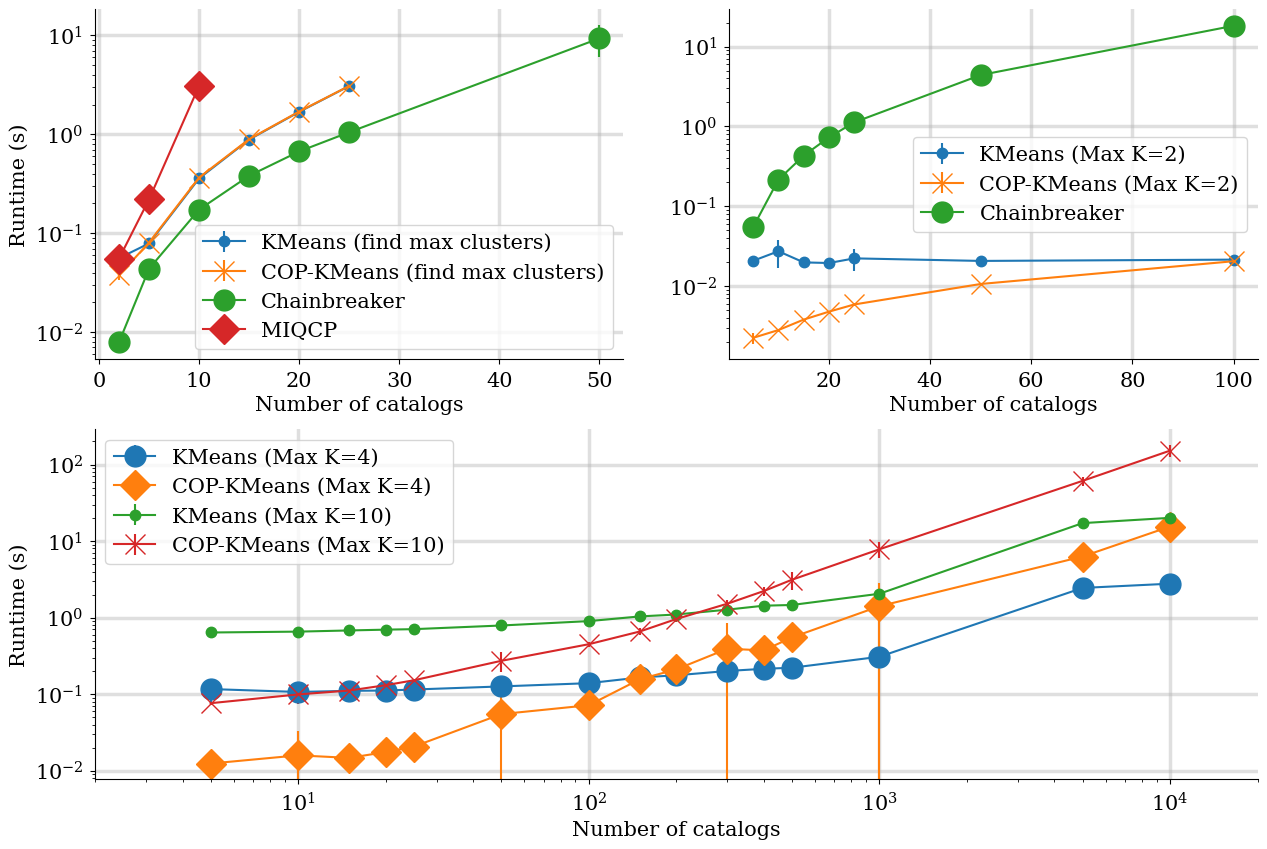

In [29]:
import matplotlib.gridspec as gridspec

# Create a figure
fig = plt.figure(figsize=(15, 10))

# Define the grid layout
gs = gridspec.GridSpec(2, 2, height_ratios=[1, 1])


# All
ax1 = fig.add_subplot(gs[0, 0])
ax1.errorbar(runtimes_all_avg.index, runtimes_all_avg['kmeans runtime'], 
             yerr=runtimes_all_std['kmeans runtime'], 
             fmt='.-', 
             label='KMeans (find max clusters)')
ax1.errorbar(runtimes_all_avg.index, runtimes_all_avg['copkmeans runtime'], 
             yerr=runtimes_all_std['copkmeans runtime'], 
             fmt='x-', 
             label='COP-KMeans (find max clusters)')
ax1.errorbar(runtimes_all_avg.index, runtimes_all_avg['chainbreaker runtime'], 
             yerr=runtimes_all_std['chainbreaker runtime'], 
             fmt='o-', 
             label='Chainbreaker')
ax1.errorbar(runtimes_all_avg.index, runtimes_all_avg['miqcp runtime'], 
             yerr=runtimes_all_std['miqcp runtime'],
             fmt='D-', 
             label='MIQCP')
# ax1.set_title('All algorithms including finding max clusters bound')
ax1.set_ylabel('Runtime (s)')
ax1.set_xlabel('Number of catalogs')
ax1.set_yscale('log')

# Max K = 2
ax2 = fig.add_subplot(gs[0, 1])
ax2.errorbar(runtimes_2_avg.index, runtimes_2_avg['kmeans runtime'], 
             yerr=runtimes_2_std['kmeans runtime'], 
             fmt='.-', 
             label='KMeans (Max K=2)')
ax2.errorbar(runtimes_2_avg.index, runtimes_2_avg['copkmeans runtime'], 
             yerr=runtimes_2_std['copkmeans runtime'], 
             fmt='x-', 
             label='COP-KMeans (Max K=2)')
ax2.errorbar(runtimes_2_avg.index, runtimes_2_avg['chainbreaker runtime'], 
             yerr=runtimes_2_std['chainbreaker runtime'], 
             fmt='o-', 
             label='Chainbreaker')
ax2.set_xlabel('Number of catalogs')
ax2.set_yscale('log')
# ax2.set_title('Approximation methods with max clusters = 2')

# Max K = 4
ax3 = fig.add_subplot(gs[1, :])
ax3.errorbar(runtimes_4_avg.index, runtimes_4_avg['kmeans runtime'], 
             yerr=runtimes_4_std['kmeans runtime'], 
             fmt='o-', 
             label='KMeans (Max K=4)')
ax3.errorbar(runtimes_4_avg.index, runtimes_4_avg['copkmeans runtime'], 
             yerr=runtimes_4_std['copkmeans runtime'], 
             fmt='D-', 
             label='COP-KMeans (Max K=4)')
ax3.set_xscale('log')
ax3.set_ylabel('Runtime (s)')

ax3.errorbar(runtimes_10_avg.index, runtimes_10_avg['kmeans runtime'], 
             yerr=runtimes_10_std['kmeans runtime'], 
             fmt='.-', 
             label='KMeans (Max K=10)')
ax3.errorbar(runtimes_10_avg.index, runtimes_10_avg['copkmeans runtime'], 
             yerr=runtimes_10_std['copkmeans runtime'], 
             fmt='x-', 
             label='COP-KMeans (Max K=10)')
# ax3.set_title('Approximation methods with higher max clusters')
ax3.set_xlabel('Number of catalogs')
ax3.set_yscale('log')
ax3.set_xlim([2,20000])

for ax in [ax1, ax2, ax3]:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(True, alpha=0.4)
    ax.legend()

plt.savefig('figures/runtimes.pdf', bbox_inches='tight')
plt.show()

# Simulated Data

[0.003633110480130368, 0.38532579099455766] [-0.200903710257066, 0.18026893989192838]


/tmp/ipykernel_9806/2987693274.py:79: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(subset['coord1 (arcseconds)'],


(<Figure size 500x500 with 1 Axes>,
 <Axes: title={'center': 'Simulated Sources'}, xlabel='x (arcseconds)', ylabel='y (arcseconds)'>)

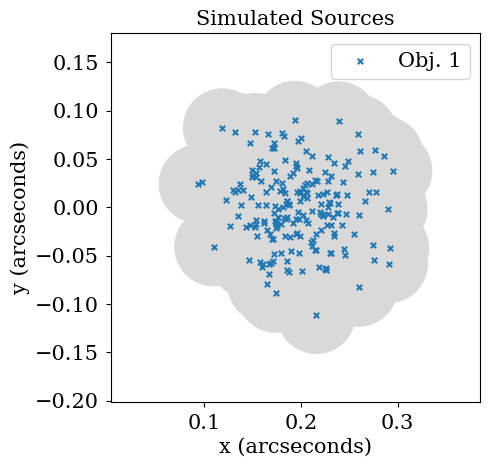

In [8]:
df = simulate_objects_on_circle(sigma=0.04, radius=0.2, num_objects=1, num_sources = 200, seed = 0)

plot_objects(df, title = 'Simulated Sources', out = None)

In [9]:
labels_cop_kmeans,best_k,_ = run_cop_kmeans(df, min_k = 1, max_k = 20, num_repeat = 1, verbose = False)
labels_kmeans,_,_ = run_kmeans(df, min_k = 1, max_k = 20, verbose = False)
labels_chain_breaking,_,_ = chain_breaking(df)

print(f'COP-KMeans MI: {normalized_mutual_info_score(df["ObjectID"], labels_cop_kmeans):.2f}')
print(f'KMeans MI: {normalized_mutual_info_score(df["ObjectID"], labels_kmeans):.2f}')
print(f'Chain-Breaking MI: {normalized_mutual_info_score(df["ObjectID"], labels_chain_breaking):.2f}')

COP-KMeans MI: 1.00
KMeans MI: 1.00
Chain-Breaking MI: 1.00


/tmp/ipykernel_9806/2987693274.py:79: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(subset['coord1 (arcseconds)'],


[0.003633110480130368, 0.38532579099455766] [-0.200903710257066, 0.18026893989192838]


/tmp/ipykernel_9806/2987693274.py:79: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(subset['coord1 (arcseconds)'],


[0.003633110480130368, 0.38532579099455766] [-0.200903710257066, 0.18026893989192838]
Uncorrected Bayes (True): -6089.14
Uncorrected Bayes (KMeans): -6128.83


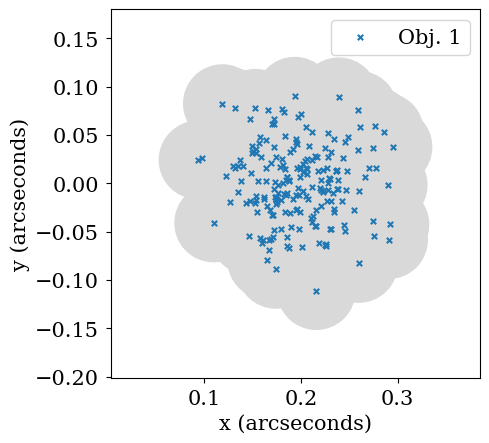

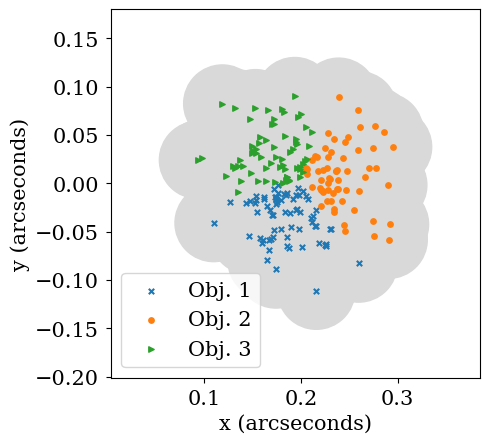

In [10]:
labels_kmeans_uncorrected,_,_ = run_kmeans(df, min_k = 1, max_k = 20, verbose = False, corrected = False)

filename_pre = 'figures/1_object_200_sources_'
fig1, ax1 = plot_objects(df, 
             colors=df["ObjectID"], 
             out=f'{filename_pre}true.pdf'
             )

fig2, ax2 = plot_objects(df, 
             colors=labels_kmeans_uncorrected, 
             out=f'{filename_pre}uncorrected.pdf'
             )
print(f'Uncorrected Bayes (True): {neg_log_bayes(df,df["ObjectID"]):.2f}')
print(f'Uncorrected Bayes (KMeans): {neg_log_bayes(df,labels_kmeans_uncorrected):.2f}')

In [11]:
print(f'Uncorrected Bayes (True): {neg_log_bayes_adjusted(df,df["ObjectID"]):.2f}')
print(f'Uncorrected Bayes (KMeans): {neg_log_bayes_adjusted(df,labels_kmeans_uncorrected):.2f}')

Uncorrected Bayes (True): -6089.14
Uncorrected Bayes (KMeans): -5475.04


[-0.2921195926333631, 0.3647023196059987] [-0.3200057982440467, 0.32197943155289915]


/var/folders/zc/6nw_r5b13ws3wfcpdxz6bzcw0000gn/T/ipykernel_68921/2385982330.py:78: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(subset['coord1 (arcseconds)'],


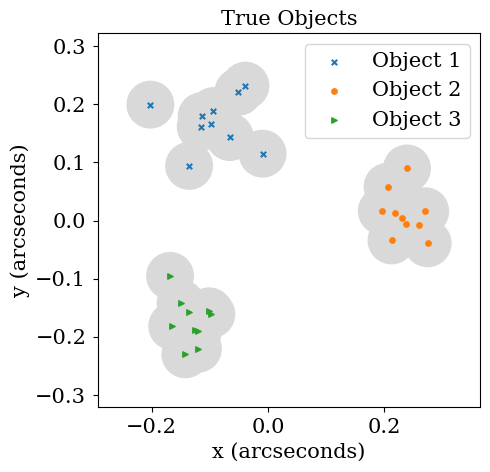

/var/folders/zc/6nw_r5b13ws3wfcpdxz6bzcw0000gn/T/ipykernel_68921/2385982330.py:78: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(subset['coord1 (arcseconds)'],


[-0.2921195926333631, 0.3647023196059987] [-0.3200057982440467, 0.32197943155289915]


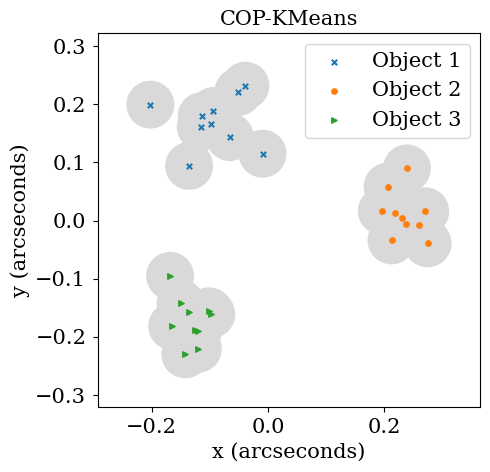

/var/folders/zc/6nw_r5b13ws3wfcpdxz6bzcw0000gn/T/ipykernel_68921/2385982330.py:78: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(subset['coord1 (arcseconds)'],


[-0.2921195926333631, 0.3647023196059987] [-0.3200057982440467, 0.32197943155289915]


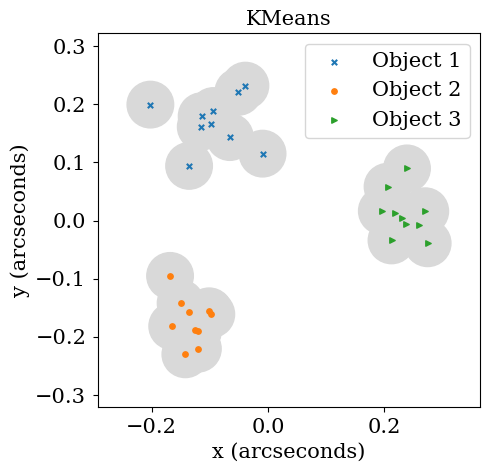

/var/folders/zc/6nw_r5b13ws3wfcpdxz6bzcw0000gn/T/ipykernel_68921/2385982330.py:78: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(subset['coord1 (arcseconds)'],


[-0.2921195926333631, 0.3647023196059987] [-0.3200057982440467, 0.32197943155289915]


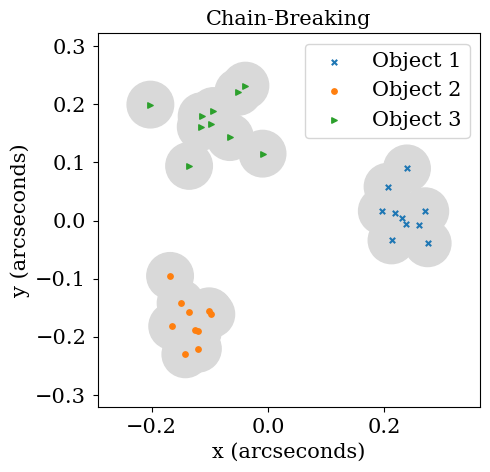

In [63]:
filename_pre = 'figures/3_objects_far_'
plot_objects(df, title='True Objects', colors=df["ObjectID"], out=f'{filename_pre}true.pdf')
plot_objects(df, title='COP-KMeans', colors=labels_cop_kmeans, out=f'{filename_pre}cop_kmeans.pdf')
plot_objects(df, title='KMeans', colors=labels_kmeans, out=f'{filename_pre}kmeans.pdf')
plot_objects(df, title='Chain-Breaking', colors=labels_chain_breaking, out=f'{filename_pre}chain_breaking.pdf')

In [32]:
# Simulate 3 objects with 10 sources each on a circle with sigma 0.04
performance = dict()
n_runs = 3
radii = [0, 0.025, 0.05, 0.075, 0.1, 0.125, 0.15, 0.175, 0.2]
for r in tqdm(radii):
    performance[r,'cop-kmeans'] = []
    performance[r,'kmeans'] = []
    performance[r,'chain-breaking'] = []
    for seed in range(n_runs):
        df = simulate_objects_on_circle(sigma=0.04, radius=r, num_objects=3, num_sources = 10, seed = seed)
        labels_cop_kmeans,_,_ = run_cop_kmeans(df, min_k = 1, max_k = 10, num_repeat = 1, verbose = False)
        labels_kmeans,_,_ = run_kmeans(df, min_k = 1, max_k = 10, verbose = False)
        labels_chain_breaking,_,_ = chain_breaking(df)
        performance[r,'cop-kmeans'].append(normalized_mutual_info_score(df["ObjectID"], labels_cop_kmeans))
        performance[r,'kmeans'].append(normalized_mutual_info_score(df["ObjectID"], labels_kmeans))
        performance[r,'chain-breaking'].append(normalized_mutual_info_score(df["ObjectID"], labels_chain_breaking))

100%|██████████| 9/9 [00:32<00:00,  3.62s/it]


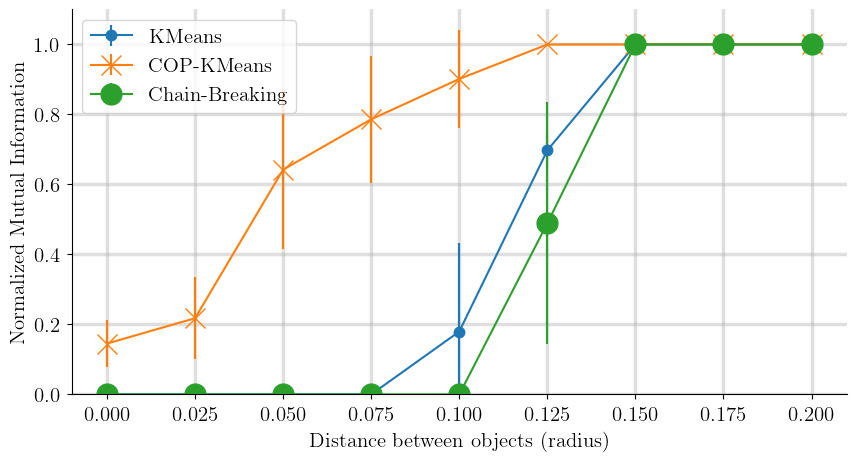

In [37]:
plt.figure(figsize=(10,5))
plt.errorbar(radii, [np.mean(performance[r,'kmeans']) for r in radii], yerr=[np.std(performance[r,'kmeans']) for r in radii], label='KMeans', linestyle='-', marker='.')
plt.errorbar(radii, [np.mean(performance[r,'cop-kmeans']) for r in radii], yerr=[np.std(performance[r,'cop-kmeans']) for r in radii], label='COP-KMeans', linestyle='-', marker='x')
plt.errorbar(radii, [np.mean(performance[r,'chain-breaking']) for r in radii], yerr=[np.std(performance[r,'chain-breaking']) for r in radii], label='Chain-Breaking', linestyle='-', marker='o')
plt.xlabel('Distance between objects (radius)')
plt.ylabel('Normalized Mutual Information')
plt.ylim([0,1.1])
plt.legend()

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(True, alpha=0.4)
# plt.title('Performance of Algorithms vs. Radius')
plt.savefig('figures/performance_radius.pdf', bbox_inches='tight')
plt.show()

# Hubble Source Catalog (HSC)

In [6]:
data_df = load_data('data/match_4000710334517.csv')
data_df

,MatchID,SubID,RA,Dec,ImageID,SourceID,X,Y,Z,Sigma,kappa,kappa (radians),log kappa (radians),coord1 (arcseconds),coord2 (arcseconds)
0,4000710334517,0,269.749758,-29.186608,0,0,-0.003813,-0.873028,-0.487656,0.024100,1721.682560,7.324928e+13,31.924890,-0.720352,0.002771
1,4000710334517,0,269.749758,-29.186608,1,1,-0.003814,-0.873028,-0.487656,0.042233,560.647048,2.385282e+13,30.802924,-0.534686,0.042572
2,4000710334517,0,269.749758,-29.186608,1,2,-0.003812,-0.873028,-0.487656,0.025386,1551.695135,6.601713e+13,31.820935,-0.880725,0.090439
3,4000710334517,0,269.749758,-29.186608,2,3,-0.003813,-0.873028,-0.487656,0.022386,1995.484155,8.489821e+13,32.072474,-0.736634,0.101140
4,4000710334517,0,269.749758,-29.186608,3,4,-0.003813,-0.873028,-0.487656,0.010583,8928.484566,3.798639e+14,33.570834,-0.726180,0.094178
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420,4000710334517,7,269.749189,-29.186707,63,420,-0.003822,-0.873027,-0.487657,0.006594,23000.000000,9.785389e+14,34.517082,1.098400,-0.270365
421,4000710334517,7,269.749189,-29.186707,75,421,-0.003822,-0.873027,-0.487657,0.006594,23000.000000,9.785389e+14,34.517082,1.111520,-0.242199
422,4000710334517,7,269.749189,-29.186707,79,422,-0.003822,-0.873027,-0.487657,0.033464,893.008876,3.799321e+13,31.268429,1.156522,-0.251002
423,4000710334517,7,269.749189,-29.186707,82,423,-0.003822,-0.873027,-0.487657,0.006594,23000.000000,9.785389e+14,34.517082,1.089730,-0.207292


In [5]:
def plot_hsc(df, colors, title, ax):
    left_x = []
    right_x = []
    top_y = []
    bottom_y = []

    colors = pd.Series(colors)

    for x, y, color, size in zip(df["coord1 (arcseconds)"],
                                df["coord2 (arcseconds)"],
                                df["ImageID"],
                                df["Sigma"]):
        # plot circles using the RGBA colors
        circle = plt.Circle((x, y), size, color=(0.85,0.85,0.85), fill=True)
        ax.add_artist(circle)

        left_x.append(x - size)
        right_x.append(x + size)
        top_y.append(y + size)
        bottom_y.append(y - size)
    # Step 3: Scatter plot with colors
    unique_colors = np.sort(colors.unique())
    for color in unique_colors:
        subset = data_df[colors == color]
        ax.scatter(subset['coord1 (arcseconds)'], 
                    subset['coord2 (arcseconds)'], 
                    s=5,
                    label=f'Object {color+1}', 
                    marker=mss[color])

    ax.set_title(f"{title}\n"
                f"Log Bayes$= {-neg_log_bayes_adjusted(df, colors):.2f}$")
    ax.set_ylabel("y")
    ax.set_xlim([min(left_x), max(right_x)])
    ax.set_ylim([min(bottom_y), max(top_y)])

    ax.set_aspect("equal")

In [67]:
labels_cop_kmeans,_,_ = run_cop_kmeans(data_df, min_k = 1, max_k = 50, num_repeat = 10, verbose = True)
labels_kmeans,_,_ = run_kmeans(data_df, min_k = 1, max_k = 50, verbose = True)

100%|██████████| 49/49 [00:11<00:00,  4.27it/s]


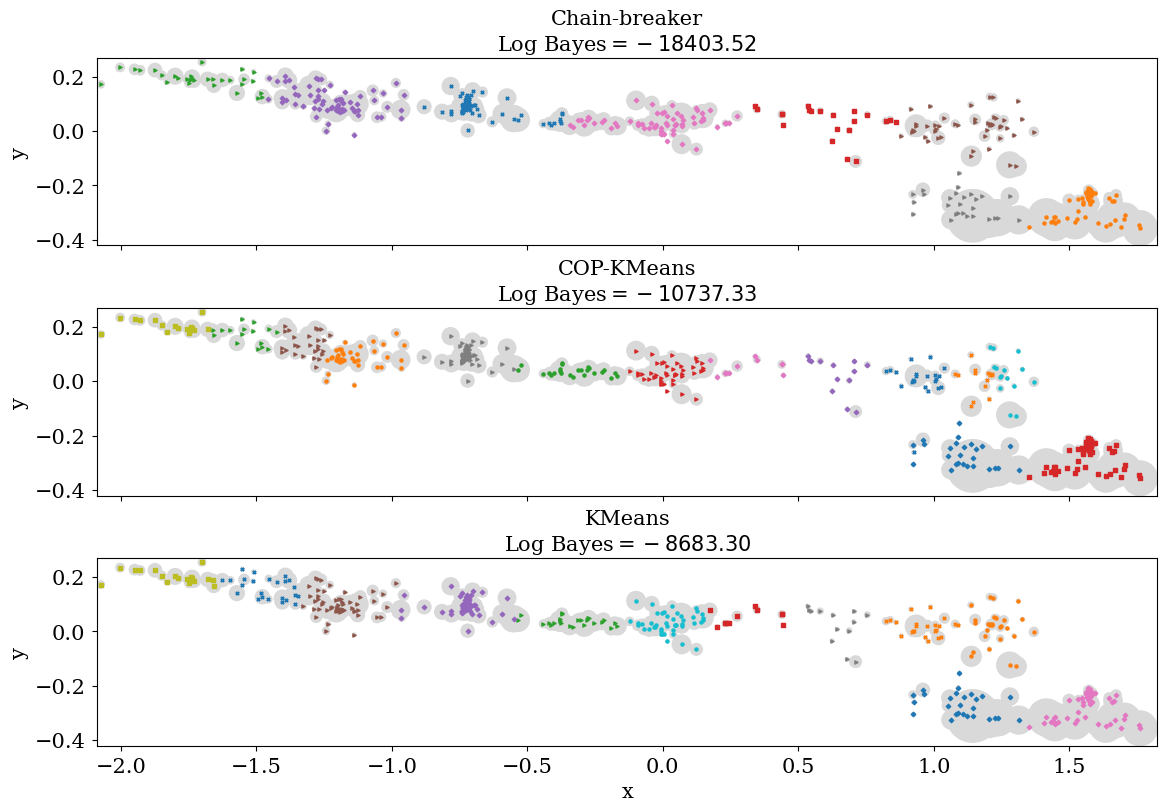

In [70]:
fig, [ax1, ax2, ax3] = plt.subplots(3, 1, figsize=(15,8), sharex=True, layout='constrained')

plot_hsc(data_df, data_df.SubID, "Chain-breaker", ax1)
plot_hsc(data_df, labels_cop_kmeans, "COP-KMeans", ax2)
plot_hsc(data_df, labels_kmeans, "KMeans", ax3)

plt.xlabel("x")

plt.savefig('figures/hsc_medium.pdf', bbox_inches='tight')
plt.show()

/var/folders/zc/6nw_r5b13ws3wfcpdxz6bzcw0000gn/T/ipykernel_31175/2421094430.py:28: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(subset['coord1 (arcseconds)'],


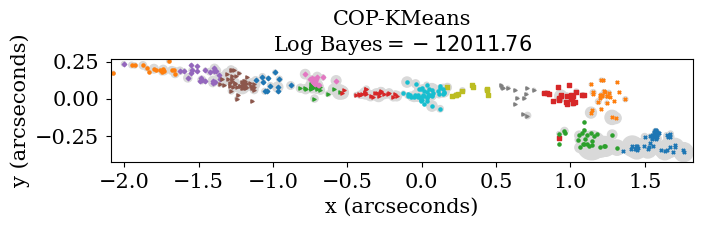

/var/folders/zc/6nw_r5b13ws3wfcpdxz6bzcw0000gn/T/ipykernel_31175/2421094430.py:28: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(subset['coord1 (arcseconds)'],


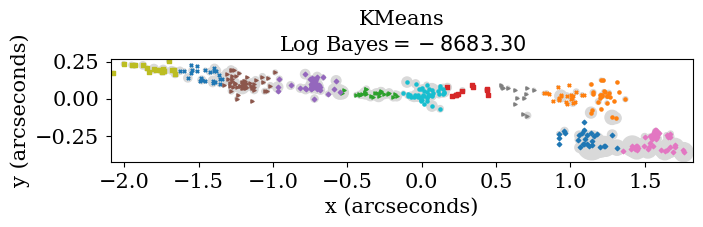

In [43]:
plot_hsc(data_df, labels_cop_kmeans, "COP-KMeans", "figures/hsc_medium_cop_kmeans.pdf")
plot_hsc(data_df, labels_kmeans, "KMeans", "figures/hsc_medium_kmeans.pdf")

In [6]:
data_df = load_data("data/match_6000204755575.csv")
data_df

,MatchID,Level,SubID,ImageID,SourceID,X,Y,Z,Sigma,RA,Dec,kappa,kappa (radians),log kappa (radians),coord1 (arcseconds),coord2 (arcseconds)
0,6000204755575,17,0,0,0,-0.609245,0.584830,-0.535532,0.018014,136.171340,-32.379990,3081.530394,1.311042e+14,32.507014,-0.462566,0.322374
1,6000204755575,17,0,1,1,-0.609245,0.584830,-0.535532,0.014955,136.171300,-32.379949,4471.381482,1.902357e+14,32.879285,-0.339688,0.301519
2,6000204755575,17,1,0,2,-0.609240,0.584834,-0.535532,0.009284,136.170901,-32.380026,11601.724041,4.935973e+14,33.832741,0.873614,0.193737
3,6000204755575,17,2,0,3,-0.609241,0.584831,-0.535535,0.013135,136.171105,-32.380175,5796.277435,2.466036e+14,33.138803,0.254267,-0.342248
4,6000204755575,17,3,0,4,-0.609244,0.584829,-0.535535,0.019333,136.171353,-32.380182,2675.468937,1.138283e+14,32.365712,-0.500021,-0.368822
5,6000204755575,17,4,0,5,-0.609243,0.584832,-0.535532,0.024001,136.171126,-32.379984,1735.901316,7.385422e+13,31.933114,0.189571,0.345358
6,6000204755575,17,5,2,6,-0.609243,0.584830,-0.535534,0.023184,136.171246,-32.380112,1860.501853,7.915537e+13,32.002434,-0.153061,-0.114746
7,6000204755575,17,5,1,7,-0.609243,0.584830,-0.535534,0.011579,136.171266,-32.380063,7458.969637,3.173431e+14,33.391005,-0.235482,-0.106740
8,6000204755575,17,5,1,8,-0.609243,0.584830,-0.535534,0.006620,136.171208,-32.380078,22817.098315,9.707573e+14,34.509098,-0.059766,-0.163652
9,6000204755575,17,5,3,9,-0.609243,0.584830,-0.535534,0.015219,136.171321,-32.380213,4317.737444,1.836989e+14,32.844319,-0.180112,-0.221155


In [7]:
labels_cop_kmeans,_,_ = run_cop_kmeans(data_df, min_k = 1, max_k = 26, num_repeat = 10, verbose = False)
labels_kmeans,_,_ = run_kmeans(data_df, min_k = 1, max_k = 26, verbose = False)

In [8]:
def plot_lined(df, labels, title, ax):
    loc_tups = [(row["coord1 (arcseconds)"], row["coord2 (arcseconds)"]) for _, row in df.iterrows()]

    label_dict = defaultdict(list)
    for tup, label in zip(loc_tups, labels):
        label_dict[label].append(tup)
        
    for label, tup_list in label_dict.items():
        if len(tup_list) == 1:
            pairs = [tup_list]
        else:
            pairs = list(itertools.combinations(tup_list, 2))
        for pair in pairs:
            x = []
            y = []
            for tup in pair:
                x.append(tup[0])
                y.append(tup[1])
            ax.plot(x, y, color='green', marker='o', linestyle='-', linewidth=1, markersize=2)
    ax.set_title(f"{title}\n"
                f"Log Bayes$= {-neg_log_bayes_adjusted(df, labels):.2f}$")
    # ax.set_ylabel("y")
    ax.set_xlabel("x")
    ax.set_aspect("equal")

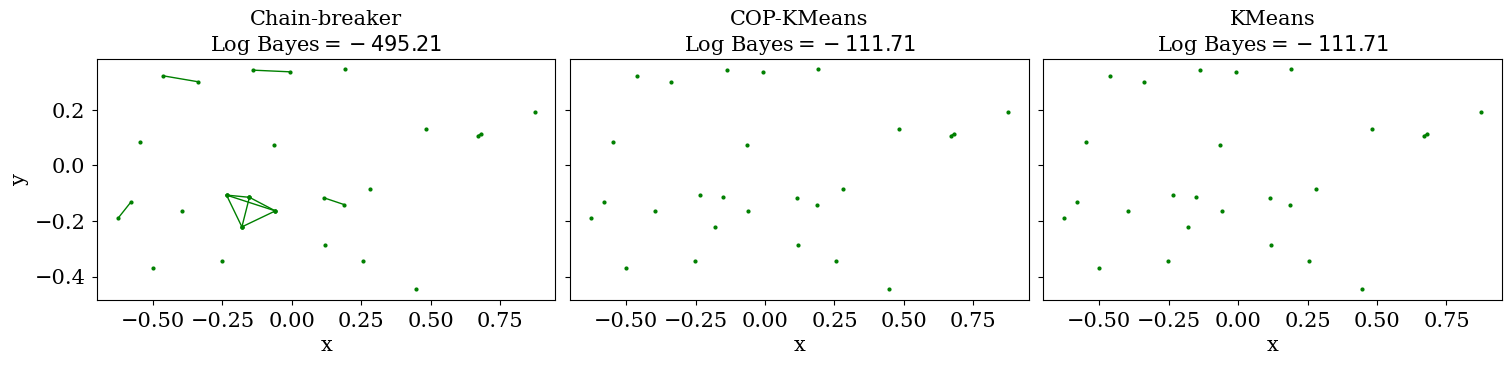

In [9]:
fig, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize=(15,10), sharey=True, layout='constrained')

plot_lined(data_df, data_df.SubID, "Chain-breaker", ax1)
plot_lined(data_df, labels_cop_kmeans, "COP-KMeans", ax2)
plot_lined(data_df, labels_kmeans, "KMeans", ax3)

ax1.set_ylabel('y')

plt.savefig('figures/hsc_small.pdf', bbox_inches='tight')
plt.show()

# Other tests

In [28]:
def setup_miqcp_model_2(data_df, max_clusters=-1, min_clusters=0, verbose=False):
    num_datapoints = data_df.shape[0]
    num_clusters = max_clusters
    if max_clusters == -1:
        num_clusters = num_datapoints
    num_catalogs = data_df["ImageID"].unique().shape[0]
    dims = 2

    C = np.log(
        constants.ARCSEC_TO_RAD_2
    )  # constant used for arcseconds to radians conversion

    model = Model("MIQCP")
    if not verbose:
        model.setParam("OutputFlag", 0)

    # Make intermediate lists and dictionaries
    candidate_list = []
    coord_dict = dict()
    kappa_dict = dict()

    for _, row in data_df.iterrows():
        source_image = (row.SourceID, row.ImageID)
        candidate_list.append(source_image)
        coord_dict[source_image] = (
            row["coord1 (arcseconds)"],
            row["coord2 (arcseconds)"],
        )
        kappa_dict[source_image] = row["kappa"]

    # Add cluster variables
    cluster_vars = model.addVars(num_clusters, dims, lb=-float("inf"), ub=float("inf"))

    # Add boolean variables (cluster-sources)
    x = model.addVars(
        candidate_list, list(range(num_clusters)), vtype=GRB.BINARY, name="x"
    )

    for (source, catalog, k), var in x.items():
        var.setAttr("BranchPriority", 1)

    # Number of clusters
    p = model.addVars(num_clusters, lb=0, vtype=GRB.BINARY)

    # Add M variable
    M = (
        np.max(pdist(data_df[["coord1 (arcseconds)", "coord2 (arcseconds)"]]))
        * data_df["kappa"].max()
        * 1.1
    )
    # M = 10**6

    # Add max cluster distance variables
    r_dict = model.addVars(candidate_list, lb=0.0, ub=float("inf"))

    # Log term
    error_threshold = 1 / 10 * np.log(data_df["kappa"].min())

    var_chi_dict = {}
    sigma_max = data_df["Sigma"].max()
    sigma_min = data_df["Sigma"].min()

    # b_list = [np.log(1/(sigma_max)**2) + C]
    # b_list = [np.log(1/(sigma_max)**2)]
    b_list = [(-2) * np.log(sigma_max)]
    # Compute b_list
    # while b_list[-1] < np.log(num_catalogs) - np.log((sigma_min)**2) + C:
    while b_list[-1] < np.log(num_catalogs) - (2 * np.log((sigma_min))):
        b_list.append(b_list[-1] + error_threshold)

    num_breakpoints = len(b_list)  # = P in the paper

    # Variables for chi
    for j in range(num_clusters):
        for b_i in range(num_breakpoints):
            var_chi_dict[("chi", j, b_i)] = model.addVar(
                vtype=GRB.BINARY, name=str(("chi", j, b_i))
            )

    s = model.addVars(num_clusters, lb=0, vtype=GRB.INTEGER)

    # Add Stirling number variables
    stirling_vars = model.addVars(range(1, num_clusters + 1), lb=0)
    z = model.addVars(range(1, num_clusters + 1), lb=0, vtype=GRB.BINARY)

    ### Objective ###
    sum_ln_kappa_rad = (C * num_datapoints) + np.log(data_df["kappa"]).sum()
    model.setObjective(
        (0.5 * r_dict.sum())
        + (np.log(2) * p.sum())
        - (np.log(2) * s.sum())
        + quicksum(
            (b_list[0] * var_chi_dict[("chi", j, 0)])
            + (
                error_threshold
                * quicksum(
                    var_chi_dict[("chi", j, b_i)] for b_i in range(1, num_breakpoints)
                )
            )
            for j in range(num_clusters)
        )
        + (p.sum() * C)
        - sum_ln_kappa_rad
        + stirling_vars.sum(),
        GRB.MINIMIZE,
    )

    ### Constraints
    # Each point assigned to a cluster
    for source, catalog in candidate_list:
        model.addConstr(
            quicksum(x[(source, catalog, j)] for j in range(num_clusters)) == 1
        )

    # |# objects|
    # p = 1 if there is a source in that cluster
    # p = 0 if no sources assigned to cluster
    for j in range(num_clusters):
        for source, catalog in candidate_list:
            model.addConstr(p[j] >= x[source, catalog, j])

    # lower bound on objects for getting a maximum object count
    model.addConstr(p.sum() >= min_clusters)

    # |# sources| * ln(2)
    for j in range(num_clusters):
        model.addConstr(
            s[j]
            == quicksum(x[source, catalog, j] for source, catalog in candidate_list)
        )

    # Each cluster has at most one source from a catalog
    sources_by_catalog = defaultdict(list)
    for source, catalog in candidate_list:
        sources_by_catalog[catalog].append(source)

    for j, c in itertools.product(range(num_clusters), range(num_catalogs)):
        model.addConstr(
            quicksum(x[(source, c, j)] for source in sources_by_catalog[c]) <= 1
        )

    # Min and max for cluster variables
    # Get coordinates
    x_coords = data_df["coord1 (arcseconds)"]
    y_coords = data_df["coord2 (arcseconds)"]

    for j in range(num_clusters):
        model.addConstr(cluster_vars[j, 0] == [min(x_coords), max(x_coords)])
        model.addConstr(cluster_vars[j, 1] == [min(y_coords), max(y_coords)])

    # Break symmetry
    first_s, first_c = candidate_list[0]
    model.addConstr(x[(first_s, first_c, 0)] == 1)

    # Big-M constraints
    for (source, catalog), coord in coord_dict.items():
        for j in range(num_clusters):
            model.addQConstr(
                (
                    kappa_dict[(source, catalog)]
                    * (  # in arcseconds^-2
                        (
                            (cluster_vars[j, 0] - coord[0])
                            * (cluster_vars[j, 0] - coord[0])
                        )
                        + (
                            (cluster_vars[j, 1] - coord[1])
                            * (cluster_vars[j, 1] - coord[1])
                        )
                    )
                )  # in arcseconds ^ 2
                <= r_dict[(source, catalog)] + (M * (1 - x[(source, catalog, j)]))
            )

    # Stirling number vars
    M2 = math.log(stirling2(num_datapoints, num_clusters)) * 2

    model.addConstr(z.sum() == 1)

    for j in range(1, num_clusters + 1):
        model.addConstr(p.sum() <= j * z[j] + num_clusters * (1 - z[j]))
        model.addConstr(p.sum() >= j * z[j])

        model.addConstr(
            stirling_vars[j] - math.log(stirling2(num_datapoints, j)) <= M2 * (1 - z[j])
        )
        model.addConstr(
            stirling_vars[j] - math.log(stirling2(num_datapoints, j))
            >= -M2 * (1 - z[j])
        )

    # Definition of variables chi
    # Equation B19
    for j in range(num_clusters):
        chi_constraint_with_b = []
        chi_constraint = []
        x_constraint = []
        for breakpoint_index in range(1, num_breakpoints):
            chi_constraint_with_b.append(
                var_chi_dict[("chi", j, breakpoint_index)]
                * (
                    np.exp(b_list[breakpoint_index])
                    - np.exp(b_list[breakpoint_index - 1])
                )
            )
        for source, catalog in candidate_list:
            x_constraint.append(x[(source, catalog, j)] * kappa_dict[(source, catalog)])
        model.addConstr(
            np.exp(b_list[0]) * var_chi_dict[("chi", j, 0)]
            + quicksum(variable for variable in chi_constraint_with_b)
            >= quicksum(variable for variable in x_constraint)
        )

        for breakpoint_index in range(num_breakpoints):
            chi_constraint.append(var_chi_dict[("chi", j, breakpoint_index)])
        for chi_index in range(len(chi_constraint) - 1):
            model.addConstr(chi_constraint[chi_index] >= chi_constraint[chi_index + 1])

    model.setParam("NumericFocus", 2)  # for numerical stability
    model.setParam("NodefileStart", 2.0)

    return model, x, stirling_vars, p, z


model, x, stirling_vars, p, z = setup_miqcp_model_2(
    df, max_clusters=5, min_clusters=0, verbose=True
)
model.optimize()

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-21
Set parameter NumericFocus to value 2
Set parameter NodefileStart to value 2
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (mac64[arm])

CPU model: Apple M2 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 528 rows, 430 columns and 1995 nonzeros
Model fingerprint: 0x2c0e852f
Model has 300 quadratic constraints
Variable types: 85 continuous, 345 integer (340 binary)
Coefficient statistics:
  Matrix range     [1e+00, 7e+03]
  QMatrix range    [6e+02, 6e+02]
  QLMatrix range   [6e-01, 3e+02]
  Objective range  [5e-01, 3e+01]
  Bounds range     [3e-01, 1e+00]
  RHS range        [2e-01, 3e+02]
  QRHS range       [2e+02, 3e+02]
Presolve removed 24 rows and 15 columns
Presolve time: 0.01s
Presolved: 504 rows, 415 columns, 2605 nonzeros
Presolved model has 5 quadratic constraint(s)
Variable types: 85 continuous, 330 integer (330 binary)

Root re

-1198.4046759214887 -1161.9630548957336
-1198.4046759214887 -1161.9630548957336
-1197.0308127908627 -1161.9630548957336
-1171.8638288595753 -1161.9630548957336
-1146.6968581895133 -1161.9630548957336


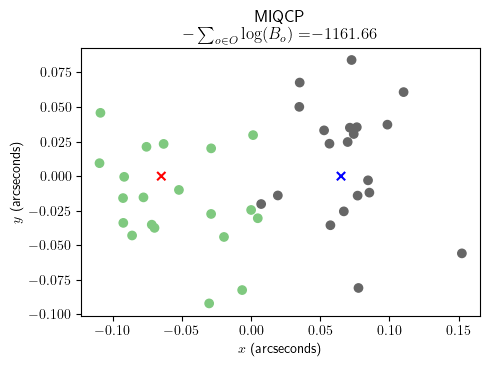

In [18]:
labels = miqcp(data_df = df, verbose = False, preDual = False, preQLinearize = False)

# labels = []
# for (_, _, j), var in x.items():
#     if var.X > 0.5:
#         labels.append(j)

# labels = pd.factorize(labels)[0]  # factorize sets labels from 0 to max_labels

plt.figure(figsize=(5, 5))
plt.title("MIQCP\n" r"$-\sum_{{o\in O}}\log(B_o)=$" f"${neg_log_bayes(df,labels):.2f}$")
plt.xlabel("$x$ (arcseconds)")
plt.ylabel("$y$ (arcseconds)")
plt.scatter(
    df["coord1 (arcseconds)"], df["coord2 (arcseconds)"], c=labels, cmap="Accent"
)
plt.tight_layout()
plt.scatter([-distance / 2, distance / 2], [0,0], c=["r", "b"], marker="x")
ax = plt.gca()
ax.set_aspect("equal")
plt.savefig(f"figures/miqcp_s1-{sigma1}_s2-{sigma2}_d-{distance}_c-{cats}_r-{seed}.eps", bbox_inches='tight')

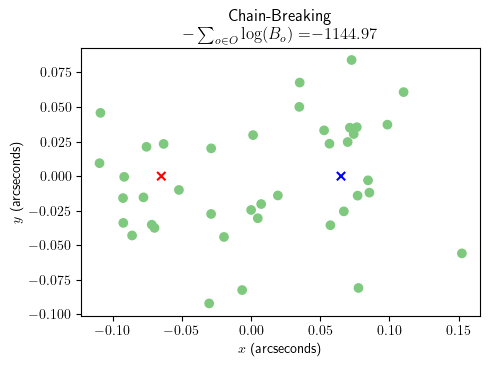

In [20]:
labels, _, _ = chain_breaking(df)

plt.figure(figsize=(5, 5))
plt.title(
    "Chain-Breaking\n"
    r"$-\sum_{{o\in O}}\log(B_o)=$"
    f"${neg_log_bayes(df,labels):.2f}$"
)
plt.xlabel("$x$ (arcseconds)")
plt.ylabel("$y$ (arcseconds)")
plt.scatter(
    df["coord1 (arcseconds)"], df["coord2 (arcseconds)"], c=labels, cmap="Accent"
)
plt.tight_layout()
plt.scatter([-distance / 2, distance / 2], [0,0], c=["r", "b"], marker="x")
ax = plt.gca()
ax.set_aspect("equal")
plt.savefig(f"figures/chain-breaking_s1-{sigma1}_s2-{sigma2}_d-{distance}_c-{cats}_r-{seed}.eps", bbox_inches='tight')

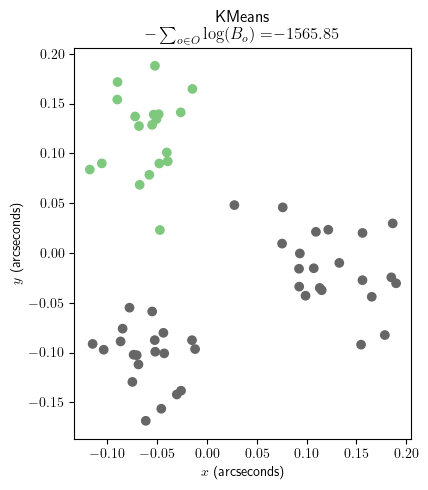

In [31]:
labels, _, _ = run_kmeans(df, min_k=1, max_k=10)

plt.figure(figsize=(5, 5))
plt.title(
    "KMeans\n" r"$-\sum_{{o\in O}}\log(B_o)=$" f"${neg_log_bayes(df,labels):.2f}$"
)
plt.xlabel("$x$ (arcseconds)")
plt.ylabel("$y$ (arcseconds)")
plt.scatter(
    df["coord1 (arcseconds)"], df["coord2 (arcseconds)"], c=labels, cmap="Accent"
)
plt.tight_layout()
ax = plt.gca()
ax.set_aspect("equal")

100%|██████████| 5/5 [00:09<00:00,  1.84s/it]


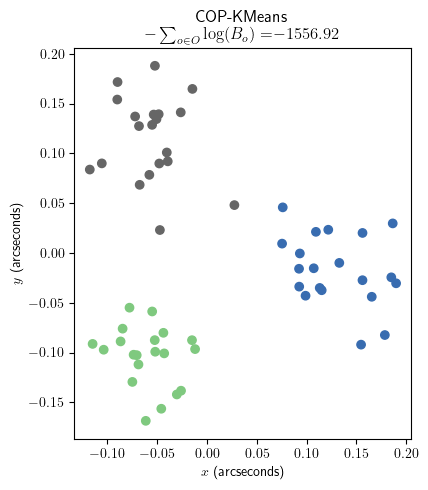

In [32]:
labels, _, _ = run_cop_kmeans(df, min_k=1, max_k=10, num_repeat=5, verbose=True)

plt.figure(figsize=(5, 5))
plt.title(
    "COP-KMeans\n" r"$-\sum_{{o\in O}}\log(B_o)=$" f"${neg_log_bayes(df,labels):.2f}$"
)
plt.xlabel("$x$ (arcseconds)")
plt.ylabel("$y$ (arcseconds)")
plt.scatter(
    df["coord1 (arcseconds)"], df["coord2 (arcseconds)"], c=labels, cmap="Accent"
)
plt.tight_layout()
ax = plt.gca()
ax.set_aspect("equal")
# plt.savefig(f"figures/presentation/cop-kmeans_s1-{sigma1}_s2-{sigma2}_d-{distance}_c-{cats}_r-{seed}.svg")

In [13]:
from functools import partial
from typing import Union
from func_timeout import func_timeout, FunctionTimedOut

class Method:
    def __init__(self, func_handle, name):
        self.func = func_handle
        self.name = name

def time_method(df: pd.DataFrame, method, repeat: int = 1):
    """Time a method.

    Args:
        df (pd.DataFrame): dataframe with coordinates and uncertainties
        method (function): method to run
        repeat (int, optional): number of time repeats. Defaults to 5.

    Returns:
        list: list of runtimes
    """
    times = []

    for _ in range(repeat):
        time_spent = 0
        try:
            start_time = time.perf_counter()

            func_timeout(2700, method, args=(df,))
            end_time = time.perf_counter()
            time_spent = end_time - start_time
        except FunctionTimedOut:
            time_spent = 1000000000

        times.append(time_spent)
    return times


def log_runtimes(
    filename: str,
    distances: list[float],
    num_cats: list[float],
    sigma1s: list[float],
    sigma2s: list[float],
    repeats: int,
    methods: list[Method]
):
    pd_dict = {
        "distance": [],
        "number of catalogs": [],
        "sigma 1": [],
        "sigma 2": [],
    }
    for m in methods:
        pd_dict[f"{m.name} Runtime"] = []
        
    for d, n, s1, s2 in itertools.product(distances, num_cats, sigma1s, sigma2s):
        print(d, n, s1, s2)
        for seed in range(repeats):
            df = simulate_two_objects(
                sigma1=s1, sigma2=s2, distance=d, num=n, seed=seed
            )
            pd_dict["distance"].append(d)
            pd_dict["number of catalogs"].append(n)
            pd_dict["sigma 1"].append(s1)
            pd_dict["sigma 2"].append(s2)
            
            for m in methods:
                time = time_method(df, m.func, repeat=1)[0]
                pd_dict[f"{m.name} Runtime"].append(time)
                
    df_times = pd.DataFrame(pd_dict)
    df_times.to_csv(filename)

In [5]:
miqcp_method = Method(miqcp, "MIQCP")
cop_kmeans_method = Method(run_cop_kmeans, "COP-KMeans")

In [15]:
# log_runtimes(
#     "runtimes/runtimes.csv", 0.13, [2, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50], 0.04, 0.04, 5
# )
log_runtimes(
    filename="runtimes/copkmeans_miqcp.csv", 
    distances=[0.13], 
    num_cats=[2, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50], 
    sigma1s = [0.04], 
    sigma2s = [0.04],
    repeats = 5,
    methods = [miqcp_method, cop_kmeans_method]
)

0.13 2 0.04 0.04
0.13 5 0.04 0.04
0.13 10 0.04 0.04
0.13 15 0.04 0.04

Interrupt request received
0.13 20 0.04 0.04

Interrupt request received


KeyboardInterrupt: 

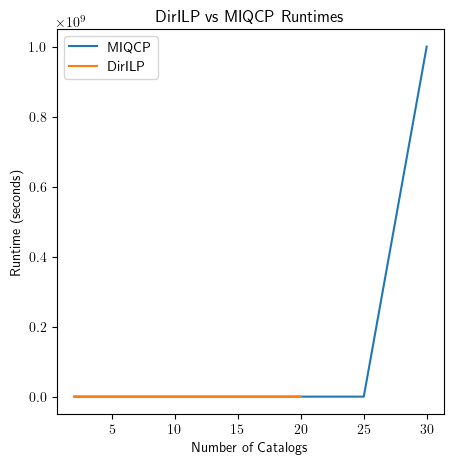

In [40]:
runtimes = pd.read_csv("runtimes2.csv")
times = runtimes["miqcp runtimes"]
miqcp_runtimes = [t.strip("][").split(", ") for t in times]
miqcp_runtimes = [float(t[0]) for t in miqcp_runtimes]

times = runtimes["dirilp runtimes"]
dirilp_runtimes = [t.strip("][").split(", ") for t in times]
dirilp_runtimes = [float(t[0]) for t in dirilp_runtimes]

for i in range(len(dirilp_runtimes)):
    if dirilp_runtimes[i] == 1000000000:
        dirilp_runtimes[i] = np.nan

plt.figure(figsize=(5, 5))
plt.title("DirILP vs MIQCP Runtimes")
plt.plot(runtimes["number of catalogs"], miqcp_runtimes)
plt.plot(runtimes["number of catalogs"], dirilp_runtimes)
plt.legend(["MIQCP", "DirILP"])
plt.xlabel("Number of Catalogs")
plt.ylabel("Runtime (seconds)")
plt.savefig("runtime_long.svg")

In [24]:
def get_percent_solved(arr):
    count = 0
    for a in arr:
        if a == 1000000000:
            count += 1
    return 100 * (1 - (count / len(arr)))


def filtered_mean_std(arr):
    arr = np.array(arr)
    arr = np.delete(arr, np.where(arr == 1000000000))
    return np.mean(arr), np.std(arr)

In [39]:
runtimes_long = pd.read_csv("runtimes3.csv", index_col=0)
cat_list = runtimes_long["number of catalogs"].unique()
miqcp_runtimes = (
    runtimes_long.groupby("number of catalogs")["miqcp runtime"].apply(list).to_dict()
)
dirilp_runtimes = (
    runtimes_long.groupby("number of catalogs")["dirilp runtime"].apply(list).to_dict()
)

miqcp_percent_solved = {k: get_percent_solved(v) for k, v in miqcp_runtimes.items()}
dirilp_percent_solved = {k: get_percent_solved(v) for k, v in dirilp_runtimes.items()}

miqcp_mean_std = {k: filtered_mean_std(v) for k, v in miqcp_runtimes.items()}
dirilp_mean_std = {k: filtered_mean_std(v) for k, v in dirilp_runtimes.items()}

/home/jacob/miniconda3/envs/research/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/jacob/miniconda3/envs/research/lib/python3.10/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/jacob/miniconda3/envs/research/lib/python3.10/site-packages/numpy/core/_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/jacob/miniconda3/envs/research/lib/python3.10/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/jacob/miniconda3/envs/research/lib/python3.10/site-packages/numpy/core/_methods.py:256: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [35]:
def plot_runtimes_error(rundict):
    x = list(rundict.keys())
    means = [v[0] for v in rundict.values()]
    stds = [v[1] for v in rundict.values()]

    plt.yscale("log")
    plt.errorbar(x, means, yerr=stds, fmt='.-')

In [ ]:
plt.figure()
plt.xlabel("Number of Catalogs")
plt.ylabel("Total Running Time (s)")
plot_runtimes_error(miqcp_mean_std)
plot_runtimes_error(dirilp_mean_std)
plt.legend(["MIQCP", "DirILP"])
plt.savefig("runtime_long.svg")

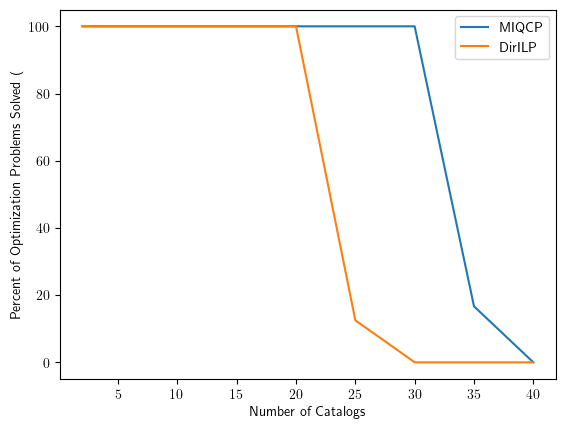

In [58]:
plt.figure()
plt.xlabel("Number of Catalogs")
plt.ylabel("Percent of Optimization Problems Solved (%)")
cats = list(miqcp_percent_solved.keys())
plt.plot(cats, [v for v in miqcp_percent_solved.values()])
plt.plot(cats, [v for v in dirilp_percent_solved.values()])
plt.legend(["MIQCP", "DirILP"])
plt.savefig("percent_solved_long.svg")

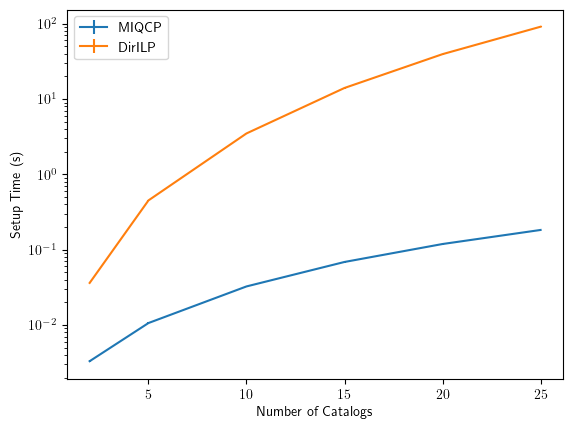

In [60]:
setuptimes = pd.read_csv("setuptime1.csv", index_col=0)
cat_list = setuptimes["number of catalogs"].unique()
miqcp_setup = (
    setuptimes.groupby("number of catalogs")["miqcp runtime"].apply(list).to_dict()
)
dirilp_setup = (
    setuptimes.groupby("number of catalogs")["dirilp runtime"].apply(list).to_dict()
)

miqcp_setup_mean_std = {k: filtered_mean_std(v) for k, v in miqcp_setup.items()}
dirilp_setup_mean_std = {k: filtered_mean_std(v) for k, v in dirilp_setup.items()}

plt.figure()
plt.xlabel("Number of Catalogs")
plt.ylabel("Setup Time (s)")
plot_runtimes_error(miqcp_setup_mean_std)
plot_runtimes_error(dirilp_setup_mean_std)
plt.legend(["MIQCP", "DirILP"])
plt.savefig("setuptimes.svg")

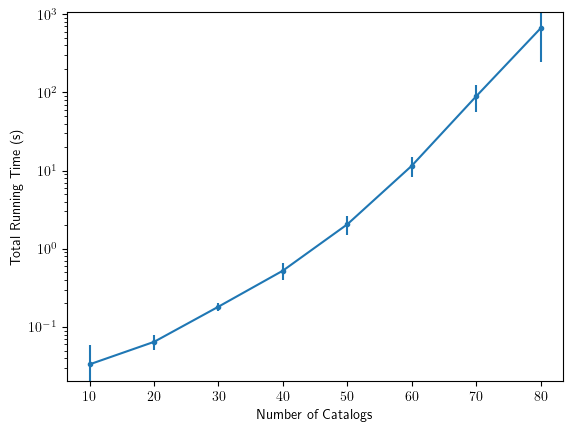

In [40]:
times = pd.read_csv("runtimes/runtime-capped.csv", index_col=0)
cat_list = times["number of catalogs"].unique()
miqcp_run = times.groupby("number of catalogs")["miqcp runtime"].apply(list).to_dict()

miqcp_mean_std = {k: filtered_mean_std(v) for k, v in miqcp_run.items()}

plt.figure()
plt.xlabel("Number of Catalogs")
plt.ylabel("Total Running Time (s)")
plot_runtimes_error(miqcp_mean_std)
# plt.savefig("capped-runtime.svg")

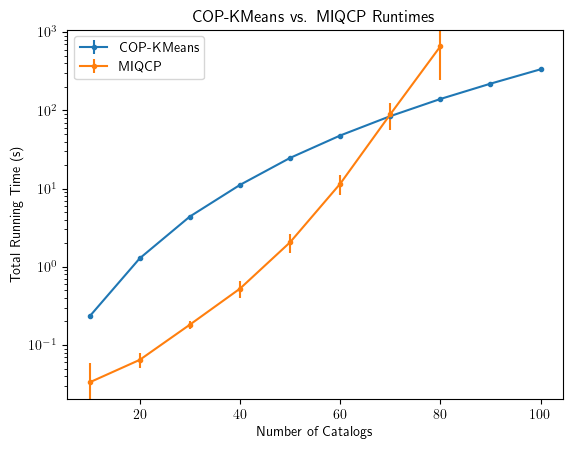

In [44]:
times = pd.read_csv("runtimes/runtime-copkmeans.csv", index_col=0)
cat_list = times["number of catalogs"].unique()
copkmeans_run = times.groupby("number of catalogs")["miqcp runtime"].apply(list).to_dict()

copkmeans_mean_std = {k: filtered_mean_std(v) for k, v in copkmeans_run.items()}

plt.figure()
plt.xlabel("Number of Catalogs")
plt.ylabel("Total Running Time (s)")
plot_runtimes_error(copkmeans_mean_std)
plot_runtimes_error(miqcp_mean_std)
plt.legend(["COP-KMeans",'MIQCP'])
plt.title("COP-KMeans vs. MIQCP Runtimes")
plt.savefig("capped-copkmeans.svg")
plt.show()

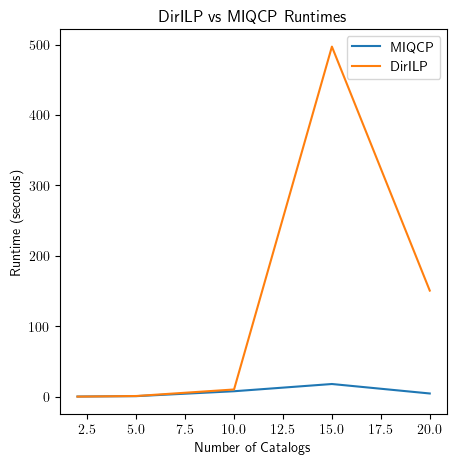

In [42]:
runtimes = pd.read_csv("runtimes2.csv")
times = runtimes["miqcp runtimes"]
miqcp_runtimes = [t.strip("][").split(", ") for t in times]
miqcp_runtimes = [float(t[0]) for t in miqcp_runtimes]

times = runtimes["dirilp runtimes"]
dirilp_runtimes = [t.strip("][").split(", ") for t in times]
dirilp_runtimes = [float(t[0]) for t in dirilp_runtimes]

for i in range(len(dirilp_runtimes)):
    if dirilp_runtimes[i] == 1000000000:
        dirilp_runtimes[i] = np.nan

plt.figure(figsize=(5, 5))
plt.title("DirILP vs MIQCP Runtimes")
plt.plot(runtimes["number of catalogs"][:-2], miqcp_runtimes[:-2])
plt.plot(runtimes["number of catalogs"][:-2], dirilp_runtimes[:-2])
plt.legend(["MIQCP", "DirILP"])
plt.xlabel("Number of Catalogs")
plt.ylabel("Runtime (seconds)")
plt.savefig("runtime_short_2.svg")